# Scatter matrix

/tmp/ipykernel_23927/3900069684.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(de, figsize=(20,20), ax=ax)


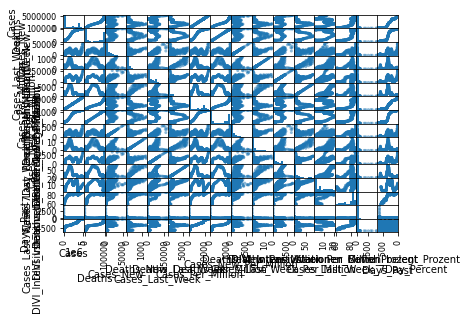

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

fig, ax = plt.subplots()
area = 'DE-total'
de = entorb.to_dataframe(area)
de.drop(columns=[c for c in de.columns if "Doubling_Time" in c], inplace=True)
pd.plotting.scatter_matrix(de, figsize=(20,20), ax=ax)
fig.set_facecolor('w')
plt.show()

# Correlation

In [2]:
corr = de.corr()
corr.style.background_gradient(cmap='Blues')

# Deaths formula:

Deaths(Cases) = 
                8                 7                 6                 5
-1.889e-47 Cases + 5.085e-40 Cases - 5.668e-33 Cases + 3.348e-26 Cases
                  4                 3                2
 - 1.107e-19 Cases + 1.971e-13 Cases - 1.63e-07 Cases + 0.07038 Cases - 123.4


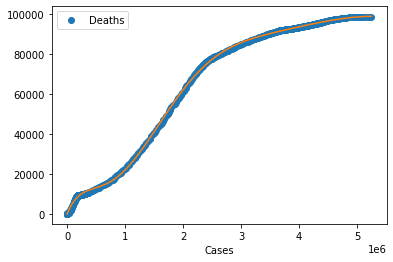

In [3]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=8)
fig, ax = plt.subplots()
de.plot(ax=ax, kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
ax.plot(de['Cases'], poly(de['Cases']))
fig.set_facecolor('w')
print("Deaths(Cases) = ")
print(poly)

-14.447865937263787

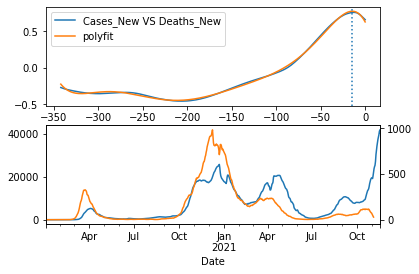

In [4]:
overlapping_days = int(0.5 * min([len(de['Cases_New']), len(de['Deaths_New'])]))

lcor = lagged_correlation = pd.DataFrame.from_dict(
    {'Cases_New VS Deaths_New': [de['Cases_New'].rolling('7D').mean().corr(de['Deaths_New'].rolling('7D').mean().shift(-t)) for t in range(overlapping_days)],
     'Delta_New': [-t for t in range(overlapping_days)]}).set_index('Delta_New')

fig, axes = plt.subplots(nrows=2)

poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases_New VS Deaths_New'], deg=7), variable='r')
lag = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][-1]
display(lag)

lcor.plot(ax=axes[0])
axes[0].plot(lcor.index, poly(lcor.index), label="polyfit")
axes[0].axvline(lag, linestyle=':')
axes[0].legend()

de['Cases_New'].rolling('7D').mean().plot(ax=axes[1])
de['Deaths_New'].rolling('7D').mean().shift(int(lag)).plot(ax=axes[1], secondary_y=True)
fig.set_facecolor('w')

In [7]:
lag = dict()
for ymax in range(30, len(de['Deaths_New']), 7):
    overlapping_days = int(0.5 * min([len(de['Cases_New'][:ymax]), len(de['Deaths_New'][:ymax])]))

    lcor = lagged_correlation = pd.DataFrame.from_dict(
        {'Cases_New VS Deaths_New': [de['Cases_New'][:ymax].rolling('7D').mean().corr(de['Deaths_New'][:ymax].rolling('7D').mean().shift(-t)) for t in range(overlapping_days)],
         'Delta_New': [-t for t in range(overlapping_days)]}).set_index('Delta_New')

    poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases_New VS Deaths_New'], deg=7), variable='r')
    if "nan" in [str(x) for x in poly.coeffs]:
        continue
    lag[de.index[ymax]] = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][-1]

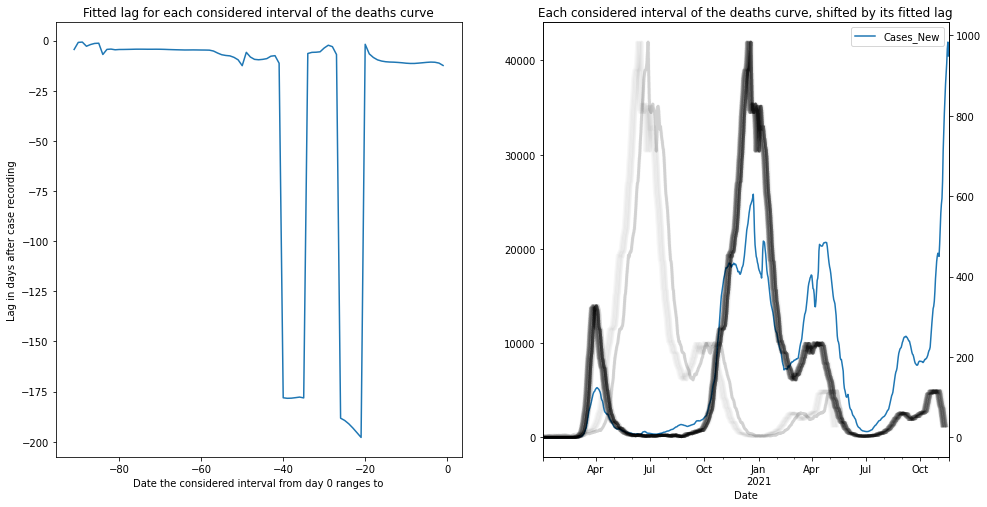

In [35]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16,8)
fig.set_facecolor('w')
keys=sorted(list(lag.keys()))
df = pd.DataFrame.from_dict({"Interval in days":keys, "Fitted lag":[lag[x] for x in keys]}).set_index("Interval in days")
multiplied = df.multiply(1)
multiplied.index = range(-len(multiplied.index), 0)
multiplied.plot(kind='line', ax=axes.flat[0], legend=False, title="Fitted lag for each considered interval of the deaths curve", xlabel="Date the considered interval from day 0 ranges to", ylabel="Lag in days after case recording")

de["Cases_New"].rolling('7D').mean().plot(kind='line', title="Each considered interval of the deaths curve, shifted by its fitted lag", ax=axes.flat[1], legend=True)

rolled = de["Deaths_New"].rolling('7D').mean()
for days, since in zip([30*(x+1) for x in range(len(keys))], lag):
    rolled.head(days).shift(int(lag[since])).plot(kind='line', linewidth=3, color=(0,0,0,3./len(keys)), label="Deaths curve", xlabel="Date", ax=axes.flat[1], secondary_y=True, legend=False)